In [1]:
from qibo import gates
import numpy as np
from qibo.models import Circuit
from qibo.gates import X, RX, RY, CZ, I
import utils.qst_qpt_functions as fun
import qutip as qt
import qililab as ql
from itertools import product
import matplotlib.pyplot as plt

from qiboconnection.connection import ConnectionConfiguration
from qiboconnection.api import API

ql.logger.setLevel(50)

2023-11-23 15:57:14,941 - qm - INFO     - Starting session: 62ebfde8-dba8-499d-a4c3-d2fc52b79496


#### Constants

In [2]:
QUBIT_A = 0
QUBIT_B = 2

NUM_SHOTS = 2000
SIMULATION = False # use this to run a simulation with qibo instead of using the qpu

In [3]:
# # my user
if not SIMULATION:
    config = ConnectionConfiguration(username="vsanchez",api_key="ea712370-7516-4cbf-91a6-72a82e39ba02")
    connection = API(configuration=config)
    connection.select_device_ids(device_ids=[9])

#### Define sequence

In [4]:
def six_operators(qubit):
    return [
        I(qubit),
        X(qubit),
        RX(qubit, np.pi/2),
        RX(qubit, -np.pi/2), 
        RY(qubit, np.pi / 2),
        RY(qubit, -np.pi / 2)
    ]

In [5]:
def bell_state_circuit(qubit_a: int, qubit_b: int, select_bell: str) -> Circuit:
    """ Generates bell circuit for bell state given by "select_bell". The circuit will have max(qubit_a, qubit_b)+1 qubits
    but only operate / measure on qubits a,b 

    Args:
        qubit_a (int): first qubit
        qubit_b (int): second qubit
        select_bell (str): name of the bell state e.g. "phi_plus"

    Returns:
        Circuit: qibo circuit without measurements to create the given bell state
    """

    c = Circuit(max(qubit_a, qubit_b) +1)

    if select_bell in {"phi_plus", "psi_minus"}:
        G1 = RY(qubit_a, -np.pi/2)
    else:
        G1 = RY(qubit_a, np.pi/2)
    if select_bell in {"phi_plus", "phi_minus"}: ## phi_plus  and phi_minus have bit flip error      A  a
        G2_prime = RY(qubit_b, -np.pi/2)
    else:
        G2_prime = RY(qubit_b, np.pi/2) 

    ## build bell state
    c.add(G1) # parameters 0 and 1 , sets the sign/ phase of the bell state
    c.add(RY(qubit_b, np.pi/2))
    c.add(CZ(qubit_a, qubit_b))
    c.add(G2_prime) # parameters 4 and 5, sets the parity of the bell state

    return c.copy()


def bell_state_tomography_circuits(qubit_a: int, qubit_b: int, select_bell: str):
    """Generates circuits needed to execute tomography for a given bell state

    Args:
        qubit_a (int): first qubit
        qubit_b (int): second qubti
        select_bell (str): name of the bell state e.g. "phi_plus"

    Returns:
        list[Circuit]: circuits for bell tomography
    """
    circuits = []

    for op1_a in six_operators(qubit_a):
        for op1_b in six_operators(qubit_b):
            circuit = Circuit(5)
            
            circuit = bell_state_circuit(qubit_a, qubit_b, select_bell)

            ## state tomography part
            circuit.add(op1_a)  # RA
            circuit.add(op1_b)  # RB
            circuit.add(gates.M(qubit_a, qubit_b))
            circuits.append(circuit)

    # We add extra 4 gates to have a reference
    for gate_a in [gates.I, gates.X]:
        for gate_b in [gates.I, gates.X]:
            circuit = Circuit(5)
            circuit.add(gate_a(qubit_a))
            circuit.add(gate_b(qubit_b))
            circuit.add(gates.M(qubit_a, qubit_b))

            circuits.append(circuit)

    return circuits

In [7]:
# to check bell states use just qubits 0,1 so that the density matrix is not that huge

# validate that we are creting the proper bell states
for select_bell in ['phi_plus', 'phi_minus', 'psi_plus', 'psi_minus']:
    circuit = bell_state_circuit(0, 1, select_bell)
    print("circuit: \n", circuit.draw(), "\n")
    print(select_bell, np.round(circuit().state(), 3), "\n")
    print("density matrix: \n", np.round(np.kron(circuit().state(), circuit().state().T).reshape(4,4),3), "\n")

circuit: 
 q0: ─RY─o────
q1: ─RY─Z─RY─ 

phi_plus [ 0.707+0.j  0.   +0.j -0.   +0.j  0.707+0.j] 

density matrix: 
 [[ 0.5+0.j  0. +0.j -0. +0.j  0.5+0.j]
 [ 0. +0.j  0. +0.j -0. +0.j  0. +0.j]
 [-0. +0.j -0. +0.j  0. -0.j -0. +0.j]
 [ 0.5+0.j  0. +0.j -0. +0.j  0.5+0.j]] 

circuit: 
 q0: ─RY─o────
q1: ─RY─Z─RY─ 

phi_minus [ 0.707+0.j  0.   +0.j  0.   +0.j -0.707+0.j] 

density matrix: 
 [[ 0.5+0.j  0. +0.j  0. +0.j -0.5+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0. +0.j]
 [-0.5+0.j -0. +0.j -0. +0.j  0.5-0.j]] 

circuit: 
 q0: ─RY─o────
q1: ─RY─Z─RY─ 

psi_plus [0.   +0.j 0.707+0.j 0.707+0.j 0.   +0.j] 

density matrix: 
 [[0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]] 

circuit: 
 q0: ─RY─o────
q1: ─RY─Z─RY─ 

psi_minus [ 0.   +0.j  0.707+0.j -0.707+0.j  0.   +0.j] 

density matrix: 
 [[ 0. +0.j  0. +0.j -0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]

#### Run jobs

In [8]:
bell_flags = ['phi_plus', 'phi_minus', 'psi_plus', 'psi_minus']

if not SIMULATION:
    bell_results_ids = {}
    for bell_flag in bell_flags:
        circuits = bell_state_tomography_circuits(QUBIT_A, QUBIT_B, select_bell=bell_flag)
        job_id = connection.execute(circuit=circuits, nshots=NUM_SHOTS)


In [9]:
connection.list_jobs().dataframe[:4]["id"].values[::-1]

array([6853, 6854, 6855, 6856])

In [10]:
# retrieve ids for each bell state
bell_results_ids = dict(zip(bell_flags, connection.list_jobs().dataframe[:4]["id"].values[::-1]))

In [11]:
def mock_results_with_qibo(bell_flag: str) -> list[dict]:
    """Outputs results from simulation with the same format as qiboconnection

    Args:
        bell_flag (str): selected bell state

    Returns:
        list[dict]: list of probabilities dictionaries. Each dictionary contains a dictionary with qubit bitstrings as keys and probabilities of the
        give bitstring as values 
    """
    results = [result(nshots=NUM_SHOTS).probabilities() for result in bell_state_tomography_circuits(QUBIT_A, QUBIT_B, select_bell=bell_flag)]

    return [
        {
            "probabilities": {
                "00": result[0],
                "01": result[1],
                "10": result[2],
                "11": result[3],
            }
        }
        for result in results
    ]

In [12]:
bell_results = {}
for bell_flag in bell_flags:
    if not SIMULATION:
        bell_results[bell_flag] = connection.get_result(job_id=int(bell_results_ids[bell_flag]))
    else:
        bell_results[bell_flag] = mock_results_with_qibo(bell_flag) # QIBO

In [ ]:
def get_probstrings_from_qiboconresults(mmt_data: list[dict], measurement=False):
    """
    Get probability data from qiboconnection results

    Args:
        mmt_data [list(dict)]: list of dictionary, each object is a dictionary with shape e.g.
        {'probabilities': {'00': 0.31275, '01': 0.29825, '10': 0.16675, '11': 0.22225}}
    """
    signs_op_diagonal = np.array(
    [[1, -1, 1, -1], [1, 1, -1, -1], [1, -1, -1, 1]]  # IZ  # ZI  # ZZ
    )
    observables = ["IZ", "ZI", "ZZ"]  # ['ZI', 'IZ', 'ZZ'] #['IZ', 'ZI', 'ZZ']

    ncircuits = len(mmt_data)
    data_combined_bitstrings = np.zeros((ncircuits, 4))
    observables_probabilities = np.zeros((ncircuits, 3))
    for k_c, data in enumerate(mmt_data):
            data_combined_bitstrings[k_c, 0] = data["probabilities"]["00"] # "00"
            data_combined_bitstrings[k_c, 1] = data["probabilities"]["01"] # "01"
            data_combined_bitstrings[k_c, 2] = data["probabilities"]["10"] # "10"
            data_combined_bitstrings[k_c, 3] = data["probabilities"]["11"] # "11"


            if not measurement:
                for i, _ in enumerate(observables):
                    observables_probabilities[k_c, i] = data_combined_bitstrings[k_c] @ signs_op_diagonal[i]

    return data_combined_bitstrings if measurement else observables_probabilities

In [ ]:
def prepare_linear_system_QST(
    measurement_calibration_weights, means_ops_Rcircuit, stds_ops_Rcircuit
):
    """
    Returns all the components of the linear system to be solved to perform process tomography.
    """
    weights_state_tomography = (fun.get_weights_state_tomography())  # has indices i, n, k, i.e., shape (3, 16, len(combs))
    beta_Mi_calibration_matrix = measurement_calibration_weights  # this should have dim (4, 3), i.e., each column
    # is a measurement operator and each row
    # the coefficient accompanying II, IZ, ZI, ZZ
    # in that order
    len_combs = 36
    coeff_matrix = np.zeros((3 * len_combs, 15))  # we only need to solve 15 variables because of normalisation (p0 = 1-\sum_{n=1} pn)
    independent_term = np.zeros(3 * len_combs)  # will be filled by self.post_processed_results
    wlsq_stds = np.zeros(3 * len_combs)

    #### means_ops_Rcircuit has shape (36, 3)
    stds_ops_Rcircuit = stds_ops_Rcircuit.reshape(36, 3) if stds_ops_Rcircuit is not None else np.zeros((36, 3))  ## so that the loop below doesn't complain
        ## we flatten it automatically when we return it in
        ## get_probabilities_data_combined_measurementops() because of convenience for the measurement
        ### calibration experiment, but for qst it's convenient to keep it separated to ensure we are not mirring the order.
        #### TODO: check whether the resulting order is indeed different from having it flattened in the first place
        # (it seems so)

    for alpha, (i, k) in enumerate(product(range(3), range(len_combs))):  # alpha from 0 to 107; i from 0 to 2; k from 0 to 35
        for n in range(15):
            coeff_matrix[alpha, n] += np.sum(
                beta_Mi_calibration_matrix[1:, i]
                * weights_state_tomography[:, n + 1, k]
            )
        # the n+1 is because the weight matrix had the identity there
        dat_means_ops = means_ops_Rcircuit[k]
        dat_stds_ops = stds_ops_Rcircuit[k]

        independent_term[alpha] = (
            dat_means_ops[i] - beta_Mi_calibration_matrix[0, i] / 4
        )
        wlsq_stds[alpha] = dat_stds_ops[i]

    if stds_ops_Rcircuit is None:
        wlsq_stds = None

    return coeff_matrix, independent_term, wlsq_stds

In [ ]:
bell_strings = ['$|00 \\rangle + |11 \\rangle$', '$|00 \\rangle - |11 \\rangle$', '$|01 \\rangle + |10 \\rangle$', '$|01 \\rangle - |10 \\rangle$']

nsubsets = 1 ## loop below hardcoded for a single subset, but in all the previous data sets there's little to no difference for tiny statistics at least

state_reconstruction_paulibasis = np.zeros((4, 16))

for bell_ind, bell_flag in enumerate(bell_flags):
    mmt_data = bell_results[bell_flag]
    dataQST, dataMMT = mmt_data[:36], mmt_data[36:]
    
    # MMT data
    means_bitstrings = get_probstrings_from_qiboconresults(dataMMT, measurement=True)
    coeffs_mat, ideal_measurements = fun.prepare_linear_system_measurement_calibration(processed_data=means_bitstrings)
    measurement_calibration_weights = fun.solve_linear_system_measurement_calibration(coeff_matrix=coeffs_mat,independent_term=ideal_measurements)
    
    # QST data
    means_measops = get_probstrings_from_qiboconresults(dataQST, measurement=False) # TODO: try other workflow with samples and see what happens
    measurement_calibration_weights = np.linalg.pinv(measurement_calibration_weights)
    coeff_matrix, independent_term, wlsq_stds = prepare_linear_system_QST(measurement_calibration_weights, means_measops, None)
    reconstructed_vector_noII = fun.solve_linear_system_QST(coeff_matrix=coeff_matrix, 
                                                        independent_term=independent_term, 
                                                        wlsq_stds=None,
                                                        initial_guess=np.zeros(15))

    state_reconstruction_paulibasis[bell_ind] = np.append(1/4, reconstructed_vector_noII)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
for bell_ind, bell_flag in enumerate(bell_flags):
    
    v = state_reconstruction_paulibasis[bell_ind]
    rh = fun.take_pauli_reconstructed_state_to_density_matrix(v)
    rh_qt = qt.Qobj(rh, dims=[[2]*2]*2)
    print(bell_flag, qt.entropy_vn(rh_qt.ptrace(0), base=2))

phi_plus 1.0
phi_minus 1.0
psi_plus 1.0
psi_minus 1.0


Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]
Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.5  0.   0.  -0.5]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-0.5  0.   0.   0.5]]
Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]
Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]


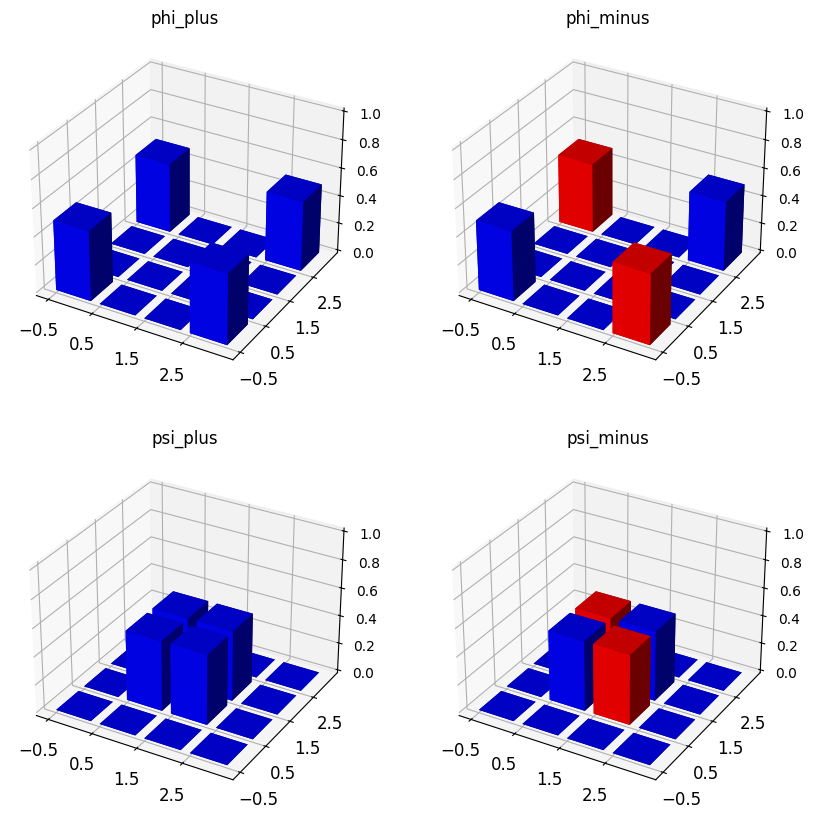

In [ ]:
fig= plt.figure(figsize=(10,10))
for bell_id, bell_flag in enumerate(bell_flags):

    v = state_reconstruction_paulibasis[bell_id]
    rh = fun.take_pauli_reconstructed_state_to_density_matrix(v)
    print(qt.Qobj(rh))
    ax = fig.add_subplot(2, 2, bell_id+1, projection='3d')
    ax.set_title(bell_flag)
    fun.plot_matrix(rh, ax=ax)

## Plot 36 states in the Pauli basis

Collection of indices of observables corresponding to first and second qubits and their correlations

In [ ]:
one_local = ['IX', 'IY', 'IZ', 'XI', 'YI', 'ZI']
two_local = [''.join(x) for x in product(['X', 'Y', 'Z'], repeat=2)]
original_order = [''.join(x) for x in product(['I', 'X', 'Y', 'Z'], repeat=2)]
final_xticklabels = one_local
final_xticklabels.extend(two_local)

index_reordering = [original_order.index(x) for x in final_xticklabels]

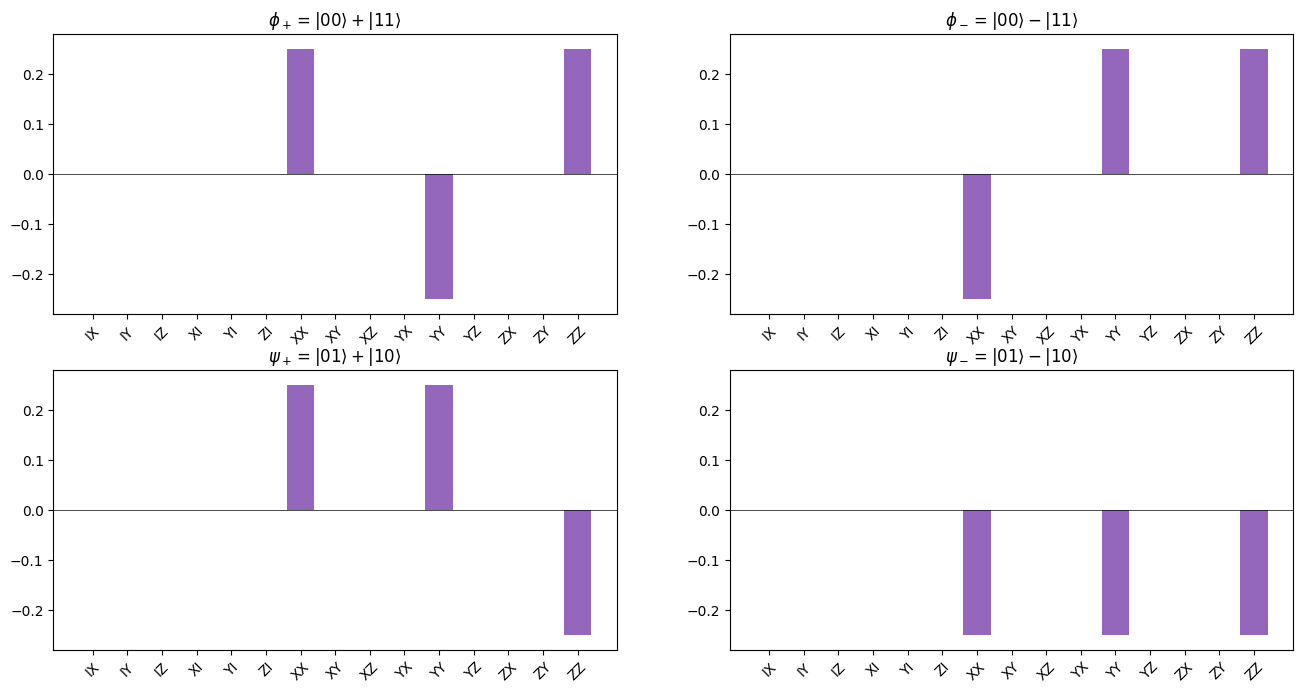

In [ ]:
bell_strings = ['$|00 \\rangle + |11 \\rangle$', '$|00 \\rangle - |11 \\rangle$', '$|01 \\rangle + |10 \\rangle$', '$|01 \\rangle - |10 \\rangle$']
fig, axes = plt.subplots(2,2, figsize = (16, 8))


for bell_ind, bell_flag in enumerate(bell_flags):
    bellflag_split = bell_flag.split('_')
    if bellflag_split[1]=='plus':
        sg = '+'
    elif bellflag_split[1]=='minus':
        sg = '-'

    jj = bell_ind % 2
    ii = bell_ind//2

    xtickslbls = [''.join(x) for x in product(['I', 'X', 'Y', 'Z'], repeat=2)]
    xtickslbls = xtickslbls[1:]

    basicrots = ['$I$', '$X_\\pi$', '$X_{\\pi/2}$', '$X_{-\\pi/2}$', '$Y_{\\pi/2}$', '$Y_{-\\pi/2}$']
    # titles = list(' '.join(x) for x in product(basicrots, repeat=2))
    titles = [''.join((x[1], x[0])) for x in product(basicrots, repeat=2)]
    indices_secondqb = [4, 8, 12]
    correlation_indices = list(range(3, 15))
    for x in indices_secondqb:
        correlation_indices.remove(x)

    ax = axes[ii, jj]
    ax.bar(range(3), state_reconstruction_paulibasis[bell_ind, 1:4], color='C0')
    ax.bar(range(3, 6), state_reconstruction_paulibasis[bell_ind, index_reordering[3:6]], color='C3')
    ax.bar(range(6, 15), state_reconstruction_paulibasis[bell_ind, index_reordering[6:]], color='C4')
    ax.set_xticks(range(15))
    ax.set_ylim(-0.28, 0.28)
    ax.set_xticklabels(final_xticklabels, rotation=45)
    ax.set_title(f'$\\{bellflag_split[0]}_{sg} = ${bell_strings[bell_ind]}')
    ax.axhline(y=0.0, color='black', linestyle='-', linewidth=0.5)
        
    # fig.savefig('qst36states_20231004_qbs2_4_nshots1000_dataset0.png')